# Adding simulated energy fluctuations to simulated data
In the experimental data we observe an energy fluctuation not present in the simulated data.
We seek to improve the classification performance on simulated data by adding similar fluctuations 
to the simulated data before training.

In [1]:
# Module and data import
import sys
import os
sys.path.append('../../../master_scripts')
import git
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.stats import cauchy
from sklearn.model_selection import train_test_split
from master_scripts.data_functions import (load_experiment, get_git_root, separation_distance, energy_difference,
                                           relative_energy, event_indices, normalize_image_data, import_real_data)
from master_scripts.plotting import plot_roc_curve
from sklearn.metrics import f1_score, roc_curve
from random import randint
%load_ext autoreload
%autoreload 2
repo_root = get_git_root()
#print(os.listdir("../../../event_classification_example/data"))
DATA_PATH = "../../../event_classification_example/data/"
tfile = "CeBr10k_1.txt"
FIG_PATH = repo_root + "figures/"

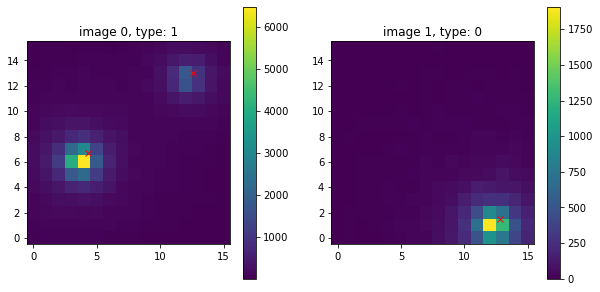

In [2]:
timages = []
tenergies = []
tpositions = []
tlabels = []
# Open the file
with open(DATA_PATH + tfile, "r") as datafile:
    # Loop over the file, line by line
    for line in datafile:
        
        # The line is still a string when read from the file. We use numpys fromstring()
        # to convert the line to a numpy array, specifying that each element is separated
        # by a space. This does not convert the line in the file, only the "copy" that we have
        # read into memory. fromstring() also removes any trailing newline ('\n') characters
        # so we don't have to worry about that. The values will be interpreted as floats.
        line = np.fromstring(line, sep=' ')
        
        # Now we pick slices of the array. The first 256 elements are 'pixels' of the detector image
        image = line[:256]
        
        # Get the two energies, at index 256 and 259.
        energy = np.array((line[256], line[259]))
        
        # And the four position values
        pos = np.array((line[257], line[258], line[260], line[261]))

        # Set label for the event. If Energy2 is 0 it is a single event. Any other values corresponds 
        # to a double event. We label single events as type 0, and doubles as type 1. We could also 
        # use Xpos2 or Ypos2 for this purpose.
        if energy[1] == 0:
            label = 0
        else:
            label = 1

        # Finally, we take the separated arrays and add them to their respective "storage" lists.
        timages.append(image)
        tenergies.append(energy)
        tpositions.append(pos)
        tlabels.append(label)

        
# We've now looped over the entire file. The only thing that remains is to convert the lists
# to numpy arrays.
timages = np.array(timages)
tenergies = np.array(tenergies)
tpositions = np.array(tpositions)
tlabels = np.array(tlabels)

# Rehape the whole set of images
timages = timages.reshape((timages.shape[0], 16, 16))

# Transpose all the images
timages = np.transpose(timages, (0, 2, 1))

%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
timage_0 = ax[0].imshow(timages[0].reshape(16, 16), origin='lower')
ax[0].plot(tpositions[0, 0], tpositions[0, 1], 'rx')
ax[0].plot(tpositions[0, 2], tpositions[0, 3], 'rx')
ax[0].set_title("image 0, type: " + str(tlabels[0]))
fig.colorbar(timage_0, ax=ax[0])

timage_1 = ax[1].imshow(timages[1].reshape(16, 16), origin='lower')
ax[1].set_title("image 1, type: " + str(tlabels[1]))
ax[1].plot(tpositions[1, 0], tpositions[1, 1], 'rx')
fig.colorbar(timage_1, ax=ax[1])
plt.show()





# Plot TRANSPOSED detector image, including positions and a colorbar
#fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#timage_0 = ax[0].imshow(timages[0], origin='lower')
#ax[0].plot(tpositions[0, 0], tpositions[0, 1], 'rx')
#ax[0].plot(tpositions[0, 2], tpositions[0, 3], 'rx')
#ax[0].set_title("image 0, type: " + str(tlabels[0]))
#fig.colorbar(timage_0, ax=ax[0])

#timage_1 = ax[1].imshow(timages[1], origin='lower')
#ax[1].set_title("image 1, type: " + str(tlabels[1]))
#ax[1].plot(tpositions[1, 0], tpositions[1, 1], 'rx')
#fig.colorbar(timage_1, ax=ax[1])

In [3]:
# Load sample data
images = np.load(repo_root + "data/sample/images_sample.npy")
positions = np.load(repo_root + "data/sample/positions_sample.npy")
energies = np.load(repo_root + "data/sample/energies_sample.npy")
labels = np.load(repo_root + "data/sample/labels_sample.npy")

# Load simulated data
#images = np.load(repo_root + "data/simulated/images_full_pixelmod.npy")
#positions = np.load(repo_root + "data/simulated/positions_full.npy")
#energies = np.load(repo_root + "data/simulated/energies_full.npy")
#labels = np.load(repo_root + "data/simulated/labels_full.npy")

# Indices for full data
#s_idx, d_idx, c_idx = event_indices(positions)

## Generating a 'suitable' distribution

[ 2.13370931  1.69073517  2.1087602  ...  3.72295773  1.01727036
 -0.21410093]


<AxesSubplot:ylabel='Count'>

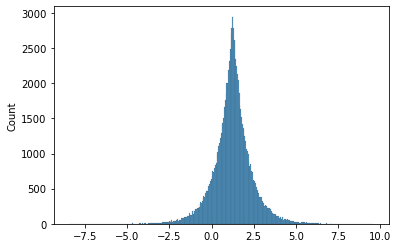

In [4]:
# Approximating hration plot From Aaron
d_mean = 1.25
d_std = 0.8117
d_size = 100000
dist= np.random.default_rng().laplace(loc=d_mean, scale=d_std, size=d_size)
print(dist)
sns.histplot(dist)

[5.0000e-03 1.5000e-02 2.5000e-02 ... 1.9975e+01 1.9985e+01 1.9995e+01]
[ 5. 50. 82. ...  0.  0.  0.]


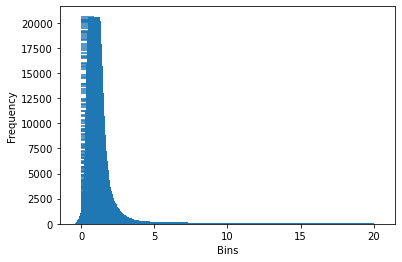

<AxesSubplot:ylabel='Count'>

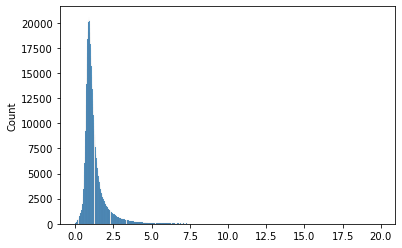

In [5]:
rdfile = np.genfromtxt("../../data/real/ratiodist.txt")
print(rdfile[:,0])
print(rdfile[:,1])

def gen_dist(x,y):
    dist = []
    for i in range(len(x)):
        for j in range(y[i]):
            dist.append(x[i])
    return dist



x = rdfile[:,0]
y = list(map(int,rdfile[:,1]))

plt.bar(x,y,align='center') # A bar chart
plt.xlabel('Bins')
plt.ylabel('Frequency')
for i in range(len(y)):
    plt.hlines(y[i],0,x[i]) # Here you are drawing the horizontal lines
plt.show()

sns.histplot(gen_dist(x,y))

#print(gen_dist(x,y))


In [6]:
#def rnoise_gen():
    #rrandom_numbers = [randint(0, len(rdfile)) for i in range(0, 16**2)]
    #weighted_rd = rdfile[:,1] #* rdfile[:,1]
    #print(weighted_rd)
    #rrandom_noise_0 = weighted_rd[rrandom_numbers]
    #return rrandom_noise_0.reshape(16,16)
    #print(rrandom_noise_0)
    #rrandom_noise_0 *= rdfile[:,1][randint(0,len(rdfile))]
    #print(rrandom_noise)
    #rzeros_hmap = np.zeros(images.shape)

#fig, ax = plt.subplots(figsize=(12, 10))
#ax.set_title('Heatmap of "noise" pixels in dataset')
#sns.heatmap(rrandom_noise_0.reshape(16, 16), square=True, ax=ax)
#rzeros_hmap = rzeros_hmap.sum(axis=0)
#ratios = (rzeros_hmap/images.shape[0]).reshape(16, 16)
##sns.heatmap(zeros_hmap.reshape(16, 16), square=True, ax=ax, annot=ratios)
##sns.heatmap(noise, square=True, ax=ax)
#ax.invert_yaxis()

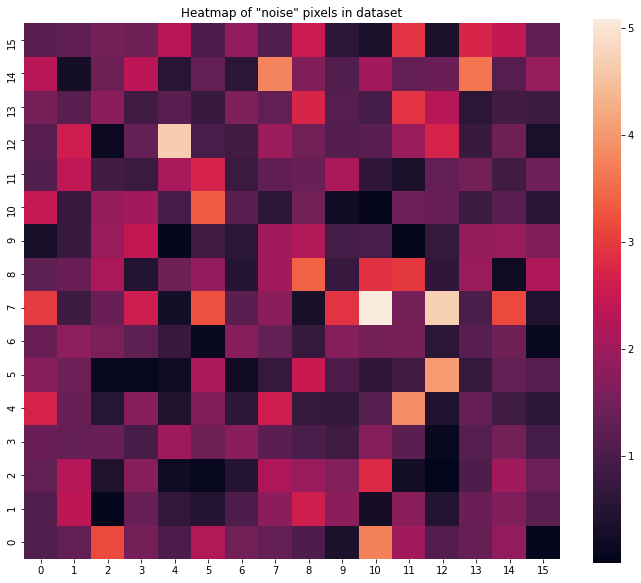

In [7]:
# Bug fixed by Julie at 2am

def noise_gen():
    random_numbers = [randint(0, len(dist)) for i in range(0, 16**2)]
    return abs(dist[random_numbers])
    
random_noise = noise_gen()
zeros_hmap = np.zeros(images.shape)

fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title('Heatmap of "noise" pixels in dataset')
sns.heatmap(random_noise.reshape(16, 16), square=True, ax=ax)
zeros_hmap = zeros_hmap.sum(axis=0)
ratios = (zeros_hmap/images.shape[0]).reshape(16, 16)
#sns.heatmap(zeros_hmap.reshape(16, 16), square=True, ax=ax, annot=ratios)
#sns.heatmap(noise, square=True, ax=ax)
ax.invert_yaxis()

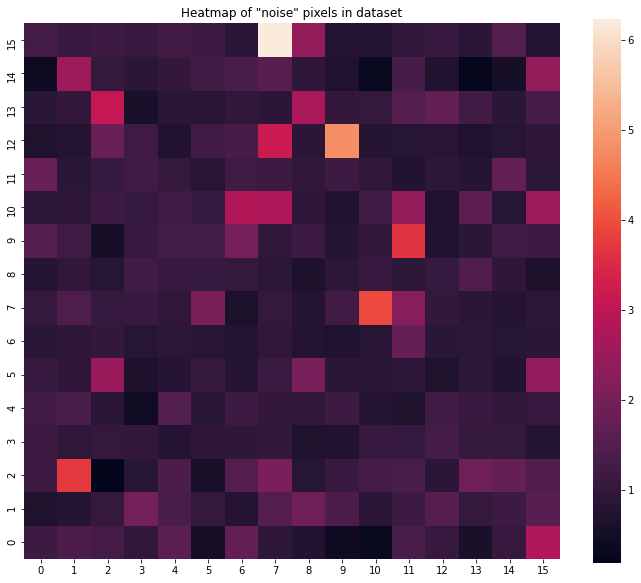

In [8]:
def rnoise_gen():
    dist = gen_dist(x,y)
    # Bug fixed by Julie at 7pm 
    dist = np.asarray(dist)
    random_numbers = [randint(0, len(dist)) for i in range(0, 16**2)]
    return abs(dist[random_numbers])
    
random_noise = rnoise_gen()
zeros_hmap = np.zeros(images.shape)

fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title('Heatmap of "noise" pixels in dataset')
sns.heatmap(random_noise.reshape(16, 16), square=True, ax=ax)
zeros_hmap = zeros_hmap.sum(axis=0)
ratios = (zeros_hmap/images.shape[0]).reshape(16, 16)
#sns.heatmap(zeros_hmap.reshape(16, 16), square=True, ax=ax, annot=ratios)
#sns.heatmap(noise, square=True, ax=ax)
ax.invert_yaxis()

(16, 16)
(256,)


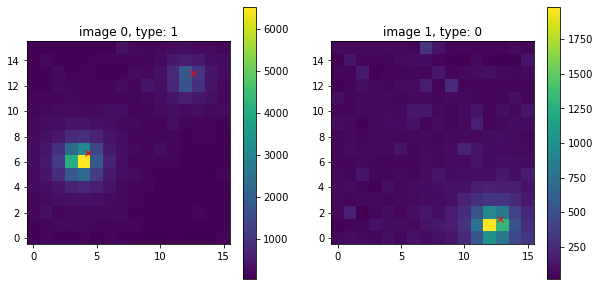

In [9]:


ntimages_0 = timages[0].reshape(16,16) + (random_noise*50).reshape(16,16)
ntimages_1 = timages[1].reshape(16,16) + (random_noise*50).reshape(16,16)

print(timages[0].shape)
print(random_noise.shape)


%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
timage_0 = ax[0].imshow(ntimages_0, origin='lower')
ax[0].plot(tpositions[0, 0], tpositions[0, 1], 'rx')
ax[0].plot(tpositions[0, 2], tpositions[0, 3], 'rx')
ax[0].set_title("image 0, type: " + str(tlabels[0]))
fig.colorbar(timage_0, ax=ax[0])

timage_1 = ax[1].imshow(ntimages_1, origin='lower')
ax[1].set_title("image 1, type: " + str(tlabels[1]))
ax[1].plot(tpositions[1, 0], tpositions[1, 1], 'rx')
fig.colorbar(timage_1, ax=ax[1])
plt.show()


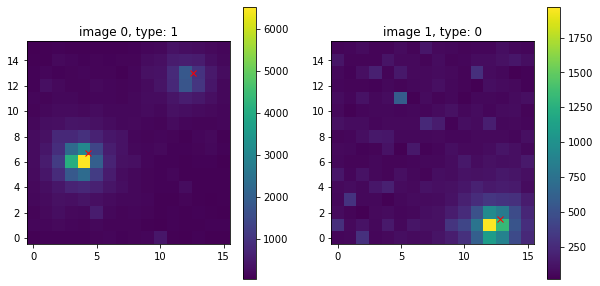

In [11]:
rimages_0 = timages[0].reshape(16,16) + (rnoise_gen()*50).reshape(16,16)
rimages_1 = timages[1].reshape(16,16) + (rnoise_gen()*50).reshape(16,16)


%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
rimage_0 = ax[0].imshow(rimages_0, origin='lower')
ax[0].plot(tpositions[0, 0], tpositions[0, 1], 'rx')
ax[0].plot(tpositions[0, 2], tpositions[0, 3], 'rx')
ax[0].set_title("image 0, type: " + str(tlabels[0]))
fig.colorbar(rimage_0, ax=ax[0])

rimage_1 = ax[1].imshow(rimages_1, origin='lower')
ax[1].set_title("image 1, type: " + str(tlabels[1]))
ax[1].plot(tpositions[1, 0], tpositions[1, 1], 'rx')
fig.colorbar(rimage_1, ax=ax[1])
plt.show()